In [1]:
%reset -sf
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
!sha1sum processed_dataframe.pkl
!pip freeze | grep ortools

e7a754fd2fbaa764f92a98a94080438670fe57b7  processed_dataframe.pkl
ortools==7.4.7247


# Define problem

In [2]:
df = pd.read_pickle("processed_dataframe.pkl")
# df

In [3]:
for i,row in df.iterrows():
    if len(row["adjacent"]) != len(row["shared_param"]): print(i)

In [4]:
nodes = pd.DataFrame()
nodes["supplies"] = [max(2,z) for z in list(df["TOTAL"])]
nodes["x"] = df["x_centre"]
nodes["y"] = df["y_centre"]

start_nodes = []
end_nodes   = []
unit_costs  = []
for i,row in df.iterrows():
    for adj, cst in zip(row["adjacent"], row["shared_param"]):
        start_nodes.append(i)
        end_nodes.append(adj)
        unit_costs.append(np.around(cst,10))

edges = pd.DataFrame()
edges["start_nodes"] = start_nodes
edges["end_nodes"]   = end_nodes
edges["unit_costs"]  = unit_costs
edges["capacities"]  = [9999999]*len(start_nodes) # disabled
edges["flows"]       = [0]*len(start_nodes)
edges["flowing"]     = [0]*len(start_nodes)
edges["names"]       = "x"+edges[["start_nodes",
                                  "end_nodes"]].astype(str).apply('-'.join, axis=1)
edges.index = edges["names"]
N = len(nodes) # the number of nodes at init

In [5]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x35-9,35,9,0.004272,9999999,0,0,x35-9
x108-52,108,52,0.013898,9999999,0,0,x108-52
x76-91,76,91,0.007216,9999999,0,0,x76-91
x165-147,165,147,0.013366,9999999,0,0,x165-147
x242-314,242,314,0.015165,9999999,0,0,x242-314


# Augment nodes to a common sink

In [6]:
def augment_nodes(nodes, edges):
    for i,ss in enumerate(nodes["supplies"]):
        edges.loc[len(edges)] = [i, N, 0, 9999999, 0, 0,
                                 "x"+str(i)+"-"+str(N)]
        edges.loc[len(edges)] = [N, i, 0, 9999999, 0, 0,
                                 "x"+str(N)+"-"+str(i)]
    nodes.loc[len(nodes)] = [-sum(nodes["supplies"]), 103.7, 1.1]
    edges.index = edges["names"]
    return nodes, edges

In [7]:
nodes, edges = augment_nodes(nodes, edges)
assert sum(nodes["supplies"]) == 0
# nodes
# edges

# Generate Adjacency matrix

In [8]:
def get_adjacency_matrix(edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    flowing = edges["flowing"]
    names = edges["names"]
    
    matrix_unit_costs = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_capacities = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flows      = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flowing    = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_names      = [["x"+str(i)+"-"+str(j)
                          for i in range(N+1)] 
                         for j in range(N+1)]
    
    for x,y,z,c,f,g in zip(start_nodes, end_nodes, unit_costs, capacities, flows, flowing):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        matrix_flowing   [x][y] = g
        
    for y,x,z,c,f,g in zip(start_nodes, end_nodes, unit_costs, capacities, flows, flowing):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        matrix_flowing   [x][y] = g

    return matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names, matrix_flowing

(matrix_unit_costs, matrix_capacities, 
 matrix_flows, matrix_names, matrix_flowing) = get_adjacency_matrix(edges)

In [9]:
# matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names
assert np.all(np.array(matrix_capacities)[:N,:N] == np.transpose(matrix_capacities)[:N,:N])
assert np.all(np.array(matrix_unit_costs)[:N,:N] == np.transpose(matrix_unit_costs)[:N,:N])

# Visualisation

In [10]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x106-98,106,98,0.000124,9999999,0,0,x106-98
x106-123,106,123,0.003733,9999999,0,0,x106-123
x45-130,45,130,0.004703,9999999,0,0,x45-130
x88-52,88,52,0.013794,9999999,0,0,x88-52
x223-225,223,225,0.013117,9999999,0,0,x223-225


In [11]:
def plot_graph(nodes, edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]

    G = nx.DiGraph()
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        G.add_edge(x, y, cost=z, capacity=c, flow=f, name=n)

    labeldict = {}
    for i,s in enumerate(nodes["supplies"]):
        labeldict[i] = int(s)

    fig, ax = plt.subplots(figsize=(14,14))
    
    pos=nx.circular_layout(G)
    pos={}
    for i,node in nodes.iterrows():
        pos[i] = [node["x"], node["y"]]
    
    for edge in G.edges(data=True):
        w = edge[2]['flow']
        if w > 0:
            size = np.log(1+w)
            nx.draw_networkx_edge_labels(G,pos, edgelist=[(edge[0],edge[1])], 
                                         edge_labels = {(edge[0],edge[1]): w})
            nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], 
                                   width=size, arrowsize=size*10)
            
    nx.draw_networkx_nodes(G, pos, with_labels=True, font_size=15, 
                           node_size=200, 
                           node_color="yellow")
    nx.draw_networkx_labels(G, pos, labels=labeldict)
    
    ax.autoscale()
    ax.set_aspect(1)
    ax.margins(0.1)
    plt.show()

In [14]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x23-74,23,74,0.001954,9999999,0,0,x23-74
x81-101,81,101,0.012206,9999999,0,0,x81-101
x1-6,1,6,0.001235,9999999,0,0,x1-6
x137-238,137,238,0.023437,9999999,0,0,x137-238
x227-231,227,231,0.006347,9999999,0,0,x227-231


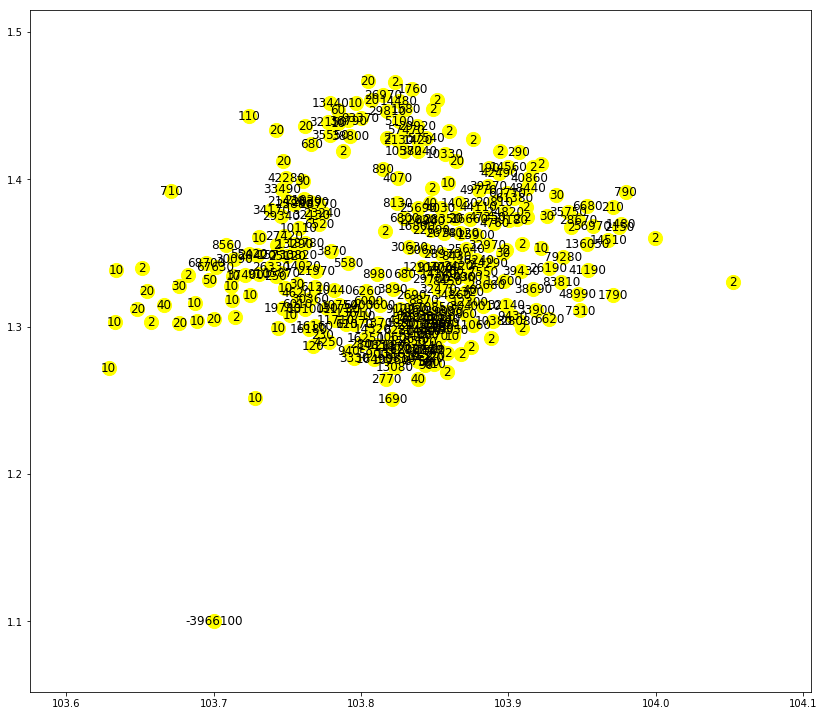

In [13]:
plt.show()
plot_graph(nodes, edges)

# Save matrices

In [18]:
np.savetxt("unit_costs.csv", matrix_unit_costs, delimiter=",")
np.savetxt("capacities.csv", matrix_capacities, delimiter=",")
np.savetxt("supplies.csv", nodes["supplies"], delimiter=",")

In [22]:
!head capacities.csv

0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,9.999999000000000000e+06,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,9.999999000000000000e+06,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,